In [15]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


# 自訂 function 可重新 reload
from importlib import reload
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *


In [16]:
def plot_intervals(index, lower_black, upper_black, lower_blue, upper_blue, lower_red, upper_red):
    import matplotlib.pyplot as plt

    # 创建图形和子图
    fig, ax = plt.subplots()
    # 设定 x 轴大小
    ax.set_xlim(-10, 10)  # 设置 x 轴范围为 0 到 10
    ax.set_ylim(0, 2) 
    # 绘制黑色信赖区间
    ax.plot([lower_black, upper_black], [1.5,1.5], color='black', linestyle='-', linewidth=2, label='theoretical')

    # 绘制蓝色信赖区间
    ax.plot([lower_blue, upper_blue], [1,1], color='blue', linestyle='-', linewidth=2, label='SSSD')

    # 绘制红色信赖区间
    ax.plot([lower_red, upper_red], [0.5,0.5], color='red', linestyle='-', linewidth=2, label='conformalized')

    # 设置纵轴刻度为空
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 添加图例
    # ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # 添加标题
    ax.set_title('Comparison of Prediction Intervals' + str(index))

    # 显示图形
    plt.show()

def case_setting(L,U, case):
    if case == 'original': # original
        L = L
        U = U
    elif case == 'narrow': # too narrow
        L = L + 0.5
        U = U - 0.5
    elif case == 'under': # under estimation case
        L = L - 3
        U = U - 3
    elif case =='over': # over estimation case
        L = L + 3
        U = U + 3
    return L, U


# Setting

In [34]:
interval_case = "over"  # case: original, narrow, under, over

# Read data

In [35]:
main_folder_path = "/home/hchuang/Documents/Project/"

# I2
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_I2/"
pred_data_I2 = read_multiple_imputations(folder_path, 1)
true_data_I2 = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data, shape: {pred_data_I2.shape}")
print(f"true_data, shape: {true_data_I2.shape}")

# test data
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_test/"
pred_data_test = read_multiple_imputations(folder_path, 1)
true_data_test = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data, shape: {pred_data_test.shape}")
print(f"true_data, shape: {true_data_test.shape}")

pred_data, shape: (100, 10000, 1, 1)
true_data, shape: (10000, 1, 1)
pred_data, shape: (100, 1000, 1, 1)
true_data, shape: (1000, 1, 1)


# Method 1

## Compute E*

In [68]:
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)

L, U = case_setting(L, U, case = interval_case) # modify interval

E_star = compute_E_star(L, U, true_data, alpha = 0.05)

L_star, U_star = adjust_PI(L, U, E_star)

print(f'E_star_L: {E_star}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

E_star_L: [[2.9838596]]
I2 CR: [[0.1611]]
I2 adjusted CR: [[0.95]]


## Adjust PI

In [69]:
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
L, U = case_setting(L,U, case = interval_case)  # modify interval
L_star, U_star = adjust_PI(L, U, E_star)
print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

test CR: [[0.154]]
test adjusted CR: [[0.95]]


# Method 2: Separate

In [36]:
# Compute E*
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)

L, U = case_setting(L, U, case = interval_case) # modify interval

E_star_L, E_star_U = compute_E_star_separate(L, U, true_data, alpha = 0.025)

L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'E_star_L: {E_star_L}, E_star_U: {E_star_U}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

# adjust PI
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
L, U = case_setting(L,U, case = interval_case)  # modify interval
L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

E_star_L: [[3.334038]], E_star_U: [[-2.70655789]]
I2 CR: [[0.1611]]
I2 adjusted CR: [[0.95]]
test CR: [[0.154]]
test adjusted CR: [[0.955]]


# compare to AR(1) theoretical interval

In [37]:
data = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/AR/test_ar1_1000_3.npy')
import os
current_directory = os.getcwd()
print("当前工作目录:", current_directory)

当前工作目录: /home/hchuang/Documents/Project/SSSD_CP/src


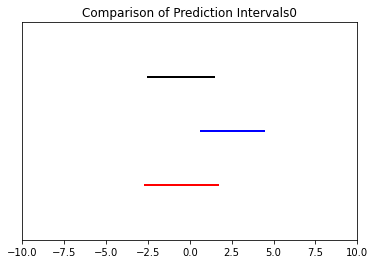

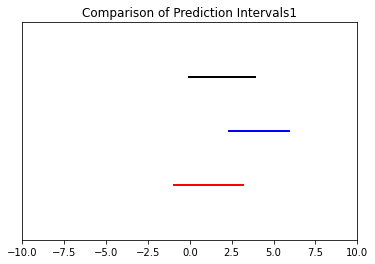

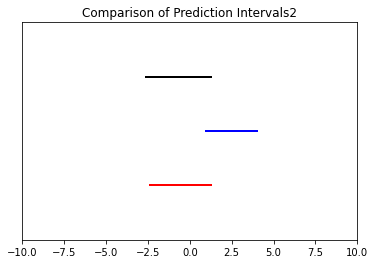

In [38]:
index = 0
for index in range(3):
    plot_intervals(index = index,
                    lower_black = data[index,1,0]*0.8 - 1.96, 
                    upper_black = data[index,1,0]*0.8 + 1.96, 
                    lower_blue = L[index,0,0],
                    upper_blue = U[index,0,0], 
                    lower_red = L_star[index,0,0], 
                    upper_red = U_star[index,0,0])

    # fig.savefig('/home/hchuang/Documents/Project/SSSD_CP/src/results/ar1-6/T200_beta00.0001_betaT0.02/CPI/plot' + str(index) +'.png')  # 可以指定文件名及路径
